# U-net type encoder-decoder convolutional neural network

## Create a U-net type encoder-decoder CNN in Keras

### Import required Python libraries



In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py   # HDF5 data file management library
from sklearn.model_selection import train_test_split
import cv2
import scipy.spatial.distance
import random
from scipy.optimize import curve_fit
from matplotlib import rc
from matplotlib import cm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from tensorflow.python.keras.layers import concatenate, UpSampling2D, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Define helper functions

In [ ]:
def image_stack_blur(image_stack, sigma_x, sigma_y):
    
    
    image_size = image_stack.shape[1] * image_stack.shape[2]
    img = []
    
    for i in range(len(image_stack)):
        
        img.append(cv2.GaussianBlur(image_stack[i], ksize=(0,0), sigmaX=sigma_x, sigmaY=sigma_y))
    
    img = np.array(img)
    img = img.reshape(len(img), image_size, 1)
    
    return(img)

### Import, process, and shape the dataset

data_path :  /content/gdrive/My Drive/Colab Notebooks/FLIM/

Input :  (37000, 128, 128, 1)
Input :  37000
Input :  (37000, 128, 128, 1)
Input :  37000
Output :  (37000, 128, 128)
Output :  37000
* Importing data *

Input :  (37000, 128, 128, 2, 1)
Output :  (37000, 128, 128, 1, 1)



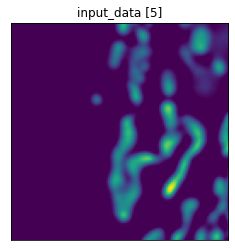

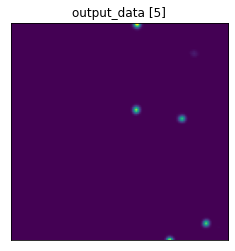

In [ ]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/FLIM/'  # nb: begin with /
print('data_path : ', data_path)
print()
input_data_filename1 = data_path + 'NewHessianMito.h5' # Mito
input_data_filename2 = data_path + 'NewHessianDrp1.h5' # Drp1

output_class_filename = data_path + 'NewHessianProc.h5'
#output_class_onehot_filename = data_path + 'output_class_onehot.h5'
#output_class_names_filename = data_path + 'output_class_names.npy'

hf = h5py.File(input_data_filename1, 'r')
input_data1 = hf.get('Mito') #Mito
input_data1 = np.array(input_data1)
input_data1= input_data1.reshape(input_data1.shape[0], 128, 128, 1)

print('Input : ', input_data1.shape)
print('Input : ', input_data1.shape[0])

hf = h5py.File(input_data_filename2, 'r')
input_data2 = hf.get('Drp1') #Drp1
input_data2 = np.array(input_data2)
input_data2= input_data2.reshape(input_data2.shape[0], 128, 128, 1)

print('Input : ', input_data2.shape)
print('Input : ', input_data2.shape[0])



input_data= np.concatenate((input_data1,input_data2),axis=3); 
input_data= input_data.reshape(input_data.shape[0], 128, 128, 2, 1)



hf = h5py.File(output_class_filename, 'r')
temp = hf.get('Proc')
output_data = np.array(temp)
print('Output : ', output_data.shape)
print('Output : ', output_data.shape[0])
output_data= output_data.reshape(output_data.shape[0], 128, 128, 1, 1)

print('* Importing data *')
print()
print('Input : ', input_data.shape)
print('Output : ', output_data.shape)
print()

# plot example

item_id = 5


plt.imshow(input_data[item_id, :, :, 0, 0], cmap='viridis')
plt.title('input_data [' + str(item_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(output_data[item_id, :, :, 0, 0], cmap='viridis')
plt.title('output_data [' + str(item_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

## Split train and test

In [ ]:
# Split data set into [test] and [train+valid] subsets using sklearn train_test_split function

data_set_test_trainvalid_ratio = 0.2
data_split_state = 42   # integer (usually 42) or None for random split on each call

print('test:[train+valid] split ratio : ', data_set_test_trainvalid_ratio)
print('data_split_state : ', data_split_state)
print()

input_train, input_test, output_train, output_test =  \
    train_test_split(input_data, output_data, \
                     test_size=data_set_test_trainvalid_ratio, random_state=data_split_state)

print('input_data : ', input_data.shape, input_data.dtype)
print('input_train : ', input_train.shape, input_train.dtype)
print('input_test : ', input_test.shape, input_test.dtype)
print()
print('output_data : ', output_data.shape, output_data.dtype)
print('output_train : ', output_train.shape, output_train.dtype)
print('output_test : ', output_test.shape, output_test.dtype)


test:[train+valid] split ratio :  0.2
data_split_state :  42

input_data :  (37000, 128, 128, 2, 1) uint8
input_train :  (29600, 128, 128, 2, 1) uint8
input_test :  (7400, 128, 128, 2, 1) uint8

output_data :  (37000, 128, 128, 1, 1) uint8
output_train :  (29600, 128, 128, 1, 1) uint8
output_test :  (7400, 128, 128, 1, 1) uint8


### Define the network hyperparameters

In [ ]:
optimizer_type = Adam(lr=0.25e-3)  # optimisation algorithm: Adam 
loss = 'mean_squared_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_absolute_error']  # network accuracy metric to be determined after each epoch
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 10  # maxmimum number of epochs to be iterated
batch_size = 256   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch

nb_filters = 16
firstConvSize = 7

### Define the network architecture

* using the Keras' *functional* model


In [ ]:
input_shape = (128, 128, 2,1)
inputs = Input(shape=input_shape)

# encoder section

down0 = Conv3D(nb_filters, (firstConvSize, firstConvSize, 2), padding='same')(inputs)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0 = Conv3D(nb_filters, (firstConvSize, firstConvSize, 2), padding='same')(down0)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(down0)
down0_pool = Reshape((64, 64, nb_filters))(down0_pool)
down0 = Reshape((128,128,nb_filters*2))(down0)
    
down1 = Conv2D(nb_filters*2, (firstConvSize, firstConvSize), padding='same')(down0_pool)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(nb_filters*2, (firstConvSize, firstConvSize), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    
# center section
    
center = Conv2D(nb_filters*4, (firstConvSize, firstConvSize), padding='same')(down1_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(nb_filters*4, (firstConvSize, firstConvSize), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
    
# decoder section with skip connections to the encoder section

up1 = UpSampling2D((2, 2))(center)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(nb_filters*2, (firstConvSize, firstConvSize), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(nb_filters*2, (firstConvSize, firstConvSize), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)

up0 = UpSampling2D((2, 2))(up1)
up0 = concatenate([down0, up0], axis=3)
up0 = Conv2D(nb_filters, (firstConvSize, firstConvSize), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)
up0 = Conv2D(nb_filters, (firstConvSize, firstConvSize), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)

outputs = Conv2D(1, (1, 1), activation='relu')(up0)

### Compile the network

In [ ]:
print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

# display a summary of the compiled neural network

print(model.summary())  
print()


* Compiling the network model *

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 2,  1584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 2,  64          conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 2,  0           batch_normalization[0][0]        
_____________________________________________________

## Load previous model

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/16layer_10epoch_7filter.h5')

## Train new model

### Train the neural network with the training dataset

In [9]:
print('* Training the compiled network *')
print()

history = model.fit(input_train, output_train, \
                    batch_size=batch_size, \
                    epochs=max_epochs, \
                    validation_split=validtrain_split_ratio, \
                    shuffle=batch_shuffle)

print()
print('Training completed')
print()

* Training the compiled network *

Epoch 1/10
93/93 [==============================] - 285s 3s/step - loss: 2.8253 - mean_absolute_error: 0.2275 - val_loss: 4.0513 - val_mean_absolute_error: 0.1246
Epoch 2/10
93/93 [==============================] - 280s 3s/step - loss: 1.5662 - mean_absolute_error: 0.0925 - val_loss: 3.2412 - val_mean_absolute_error: 0.0680
Epoch 3/10
93/93 [==============================] - 280s 3s/step - loss: 1.1572 - mean_absolute_error: 0.0664 - val_loss: 3.0134 - val_mean_absolute_error: 0.0598
Epoch 4/10
93/93 [==============================] - 280s 3s/step - loss: 0.9516 - mean_absolute_error: 0.0618 - val_loss: 2.1786 - val_mean_absolute_error: 0.0526
Epoch 5/10
93/93 [==============================] - 280s 3s/step - loss: 0.8096 - mean_absolute_error: 0.0515 - val_loss: 0.9995 - val_mean_absolute_error: 0.0409
Epoch 6/10
93/93 [==============================] - 280s 3s/step - loss: 0.7105 - mean_absolute_error: 0.0472 - val_loss: 1.4734 - val_mean_absolute_e

### Plot the training history of the network

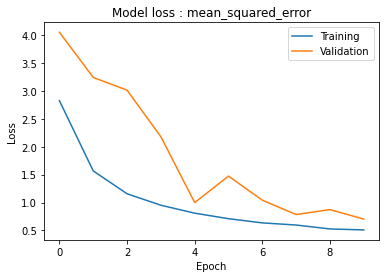

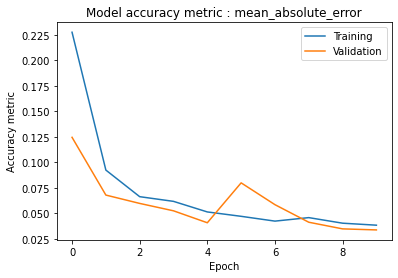

Average validation loss:  0.9752921104431153
Average training loss:  0.5958152055740357
Average validation accuracy:  0.04973304644227028
Average training accuracy:  0.042900112271308896


In [10]:
# model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history.history[metrics[0]]))
plt.plot(np.array(history.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

AverageLossVal=history.history['val_loss']
AverageLossVal=sum(AverageLossVal[-5:])/len(AverageLossVal[-5:])

AverageLossTrain=history.history['loss']
AverageLossTrain=sum(AverageLossTrain[-5:])/len(AverageLossTrain[-5:])

AverageAccTrain=history.history[metrics[0]]
AverageAccTrain=sum(AverageAccTrain[-5:])/len(AverageAccTrain[-5:])

AverageAccVal=history.history['val_' + metrics[0]]
AverageAccVal=sum(AverageAccVal[-5:])/len(AverageAccVal[-5:])

print('Average validation loss: ', AverageLossVal)
print('Average training loss: ', AverageLossTrain)
print('Average validation accuracy: ', AverageAccVal)
print('Average training accuracy: ', AverageAccTrain)



### Evaluate the trained network performance on the unseen test dataset

In [11]:
print('* Evaluating the performance of the trained network on the unseen test dataset *')
print()

evaluate_model = model.evaluate(x=input_test, y=output_test)
loss_metric = evaluate_model [0]
accuracy_metric = evaluate_model [1]

print()
print('Accuracy - ' + metrics[0] + ': %0.3f'%accuracy_metric)
print('Loss - ' + loss + ': %0.3f'%loss_metric)

* Evaluating the performance of the trained network on the unseen test dataset *

232/232 [==============================] - 20s 88ms/step - loss: 0.7205 - mean_absolute_error: 0.0340

Accuracy - mean_absolute_error: 0.034
Loss - mean_squared_error: 0.720


### Predict the output of a given input

In [14]:
print('* Predicting the output of a given input from test set *')
print()

OutputMovie = np.zeros([input_test.shape[0],128,128],dtype='uint8')
for i in range(input_test.shape[0]):
#for i in range(2000):
  test_id = i


  input_predict = np.zeros(shape=(1, 128, 128, 2, 1))  # create numpy array of required dimensions for network input

  input_predict[0, :, :, :, 0] = input_test[test_id, :, :, :, 0]  # reshaping test input image

  output_predict = model.predict(input_predict)


  print('test_id : ', test_id)
  print()

  # plot prediction example from test set

  #plt.imshow(input_test[test_id, :, :, 0, 0], cmap='gray')
  #plt.title('input_test [' + str(test_id) + ']')
  #plt.grid(None)
  #plt.xticks([])
  #plt.yticks([])
  #plt.show()

  #print()

  #plt.imshow(input_test[test_id, :, :, 1, 0], cmap='gray')
  #plt.title('input_test [' + str(test_id) + ']')
  #plt.grid(None)
  #plt.xticks([])
  #plt.yticks([])
  #plt.show()

  #print()

  #plt.imshow(output_predict[0, :, :, 0], cmap='gray')
  #plt.title('output_predict')
  #plt.grid(None)
  #plt.xticks([])
  #plt.yticks([])
  #plt.show()

  #print()

  #plt.imshow(output_test[test_id, :, :, 0, 0], cmap='gray')
  #plt.title('output_test [' + str(test_id) + ']')
  #plt.grid(None)
  #plt.xticks([])
  #plt.yticks([])
  #plt.show()

  OutputMovie[i,:,:]=output_predict[0,:,:,0]




Streaming output truncated to the last 5000 lines.

test_id :  4901

test_id :  4902

test_id :  4903

test_id :  4904

test_id :  4905

test_id :  4906

test_id :  4907

test_id :  4908

test_id :  4909

test_id :  4910

test_id :  4911

test_id :  4912

test_id :  4913

test_id :  4914

test_id :  4915

test_id :  4916

test_id :  4917

test_id :  4918

test_id :  4919

test_id :  4920

test_id :  4921

test_id :  4922

test_id :  4923

test_id :  4924

test_id :  4925

test_id :  4926

test_id :  4927

test_id :  4928

test_id :  4929

test_id :  4930

test_id :  4931

test_id :  4932

test_id :  4933

test_id :  4934

test_id :  4935

test_id :  4936

test_id :  4937

test_id :  4938

test_id :  4939

test_id :  4940

test_id :  4941

test_id :  4942

test_id :  4943

test_id :  4944

test_id :  4945

test_id :  4946

test_id :  4947

test_id :  4948

test_id :  4949

test_id :  4950

test_id :  4951

test_id :  4952

test_id :  4953

test_id :  4954

test_id :  4955

test_id :  49

## Save model

In [13]:
model.save('/content/gdrive/My Drive/Colab Notebooks/16layer_10epoch_7filter.h5')

###Save test output

#Evaluate true/false positives/negatives

###Calculate % true/false positives/negatives

In [42]:
# more description here: https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gae57b028a2b2ca327227c2399a9d53241


#for i in range(OutputMovie.shape[0]):

TruePosAreas=[]
TruePosIntInts1=[]
TruePosIntInts2=[]
TruePosIntMax1=[]
TruePosIntMax2=[]
FalsePosAreas=[]
FalsePosIntInts=[]
FalsePosIntMax=[]
FalseNegAreas=[]
FalseNegIntInts=[]
FalseNegIntMax=[]

AllGTAreas=[]
AllGTIntInts=[]
AllGTIntMax=[]
AllPredictedAreas=[]
AllPredictedIntInts=[]
AllPredictedIntMax=[]

TotalTruePositives=0
TotalFalsePositives=0
TotalFalseNegatives=0

ThresIntPred = 40
ThresIntGT = 65
MaxDist = 5
ThresAreaPred = 1
ThresAreaGT = 1

MaxPredReadout=[]
MaxGTReadout=[]

Edge=1

for i in range(OutputMovie.shape[0]):
  #img = cv2.imread('eGaIy.jpg', 0)
  img = cv2.threshold(OutputMovie[i,:,:], ThresIntPred, 255, cv2.THRESH_BINARY)[1]  # ensure binary
  num_labels, labels_im = cv2.connectedComponents(img)
  img_new1=np.zeros(img.shape,dtype=img.dtype)
  for labelIdx in range(num_labels-1):
    #test if labels_im has area larger than some threshold
    SizeLabel=np.sum(labels_im==labelIdx+1)
    if SizeLabel>ThresAreaPred:
      img_new1=np.add(img_new1,labels_im==labelIdx+1)
    #generate new binary image
  img_new1[0:Edge-1,0:Edge-1]=0
  img_new1[-Edge:,-Edge:]=0
  connectivity=8
  output=cv2.connectedComponentsWithStats(img_new1, connectivity, cv2.CV_32S)
  
  # The first cell is the number of labels
  num_labels1 = output[0]
  # The second cell is the label matrix
  labels1 = output[1]
  # The third cell is the stat matrix
  stats1 = output[2]
  
  # The fourth cell is the centroid matrix
  centroids1 = output[3]

  NoObjects1=num_labels1-1

  #print('Objects in predicted image: ',NoObjects1)
  #print()

  img = cv2.threshold(output_test[i, :, :, 0, 0], ThresIntGT, 255, cv2.THRESH_BINARY)[1]  # ensure binary
  num_labels, labels_im = cv2.connectedComponents(img)
  img_new2=np.zeros(img.shape,dtype=img.dtype)
  for labelIdx in range(num_labels-1):
    #test if labels_im has area larger than some threshold
    SizeLabel=np.sum(labels_im==labelIdx+1)
    if SizeLabel>ThresAreaGT:
      img_new2=np.add(img_new2,labels_im==labelIdx+1)
    #generate new binary image
  img_new2[0:Edge-1,0:Edge-1]=0
  img_new2[-Edge:,-Edge:]=0
  connectivity=8
  output=cv2.connectedComponentsWithStats(img_new2, connectivity, cv2.CV_32S)
  # The first cell is the number of labels
  num_labels2 = output[0]
  # The second cell is the label matrix
  labels2 = output[1]
  # The third cell is the stat matrix
  stats2 = output[2]
  # The fourth cell is the centroid matrix
  centroids2 = output[3]

  NoObjects2=num_labels2-1

  if num_labels1+num_labels2 > 2:
    Dists=scipy.spatial.distance.cdist(centroids1[1:,:], centroids2[1:,:], metric='euclidean')
    ii=np.argwhere(Dists < MaxDist)

    TruePositives=ii.shape[0]

    AllSpotsIn1=list(range(0,num_labels1-1))
    AllSpotsIn2=list(range(0,num_labels2-1))


    SpotsIn1=ii[:,0]
    SpotsIn2=ii[:,1]

    ExtraSpotsIn1=list(set(AllSpotsIn1).symmetric_difference(set(SpotsIn1)))
    ExtraSpotsIn2=list(set(AllSpotsIn2).symmetric_difference(set(SpotsIn2)))

    for p in SpotsIn1:
      TruePosAreas.append(stats1[p+1,cv2.CC_STAT_AREA])
    for p in ExtraSpotsIn1:
      FalsePosAreas.append(stats1[p+1,cv2.CC_STAT_AREA])
    for p in ExtraSpotsIn2:
      FalseNegAreas.append(stats2[p+1,cv2.CC_STAT_AREA])

    
    #plt.imshow(np.multiply(OutputMovie[i,:,:],img_new1), cmap='jet')
    #plt.title('Prediction [' + str(i) + ']')
    #plt.grid(None)
    #plt.xticks([])
    #plt.yticks([])
    #plt.show()
    #plt.imshow(np.multiply(output_test[i, :, :, 0, 0],img_new2), cmap='jet')
    #plt.title('Ground truth [' + str(i) + ']')
    #plt.grid(None)
    #plt.xticks([])
    #plt.yticks([])
    #plt.show()
    print()
    print('Predicted spots: ',AllSpotsIn1)
    print('Ground truth spots: ',AllSpotsIn2)
    print('Matched predictions: ',SpotsIn1)
    print('Matched ground truths: ',SpotsIn2)
    print('False positives: ',ExtraSpotsIn1)
    print('False negatives:',ExtraSpotsIn2)

    for p in range(NoObjects1):
      AllPredictedAreas.append(stats1[p+1,cv2.CC_STAT_AREA])
      AllPredictedIntInts.append(np.sum(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
      AllPredictedIntMax.append(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))

    for p in range(NoObjects2):
      AllGTAreas.append(stats2[p+1,cv2.CC_STAT_AREA])
      AllGTIntInts.append(np.sum(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
      AllGTIntMax.append(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))

    for p in SpotsIn1:
      #print('//True:',p)
      TruePosIntInts1.append(np.sum(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
      TruePosIntMax1.append(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))

    for p in SpotsIn2:
      TruePosIntInts2.append(np.sum(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
      TruePosIntMax2.append(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))

    for p in ExtraSpotsIn1:
      #print('//False pos:', p)
      FalsePosIntInts.append(np.sum(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
      FalsePosIntMax.append(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))

    for p in ExtraSpotsIn2:
      #print('//False Neg:',p)
      FalseNegIntInts.append(np.sum(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
      FalseNegIntMax.append(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))

    if NoObjects1>TruePositives:
      FalsePositives=NoObjects1-TruePositives
    else: 
      FalsePositives=0

    if NoObjects2>TruePositives:
      FalseNegatives=NoObjects2-TruePositives
    else:
      FalseNegatives=0
    


  else:
    TruePositives=0
    FalsePositives=0
    FalseNegatives=0

  TotalTruePositives=TotalTruePositives+TruePositives
  TotalFalsePositives=TotalFalsePositives+FalsePositives
  TotalFalseNegatives=TotalFalseNegatives+FalseNegatives

  MaxPredReadout.append(np.max(OutputMovie[i,:,:]))
  MaxGTReadout.append(np.max(output_test[i, :, :, 0, 0]))

  
print()
print()
print('Total true positives:', TotalTruePositives,'(',TotalTruePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives),'%)')
print('Total false positives:', TotalFalsePositives,'(',TotalFalsePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives),'%)')
print('Total false negatives:', TotalFalseNegatives,'(',TotalFalseNegatives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives),'%)')


Streaming output truncated to the last 5000 lines.
Matched ground truths:  [0]
False positives:  []
False negatives: []

Predicted spots:  [0]
Ground truth spots:  [0]
Matched predictions:  [0]
Matched ground truths:  [0]
False positives:  []
False negatives: []

Predicted spots:  [0]
Ground truth spots:  [0]
Matched predictions:  [0]
Matched ground truths:  [0]
False positives:  []
False negatives: []

Predicted spots:  []
Ground truth spots:  [0]
Matched predictions:  []
Matched ground truths:  []
False positives:  []
False negatives: [0]

Predicted spots:  [0]
Ground truth spots:  [0]
Matched predictions:  [0]
Matched ground truths:  [0]
False positives:  []
False negatives: []

Predicted spots:  [0, 1]
Ground truth spots:  [0]
Matched predictions:  [1]
Matched ground truths:  [0]
False positives:  [0]
False negatives: []

Predicted spots:  [0]
Ground truth spots:  []
Matched predictions:  []
Matched ground truths:  []
False positives:  [0]
False negatives: []

Predicted spots:  [0]

###Calculate weighed % true/false positives/negatives

###Initiate global variables

In [16]:
Performance=np.empty((0,8), float)

In [17]:
# more description here: https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gae57b028a2b2ca327227c2399a9d53241


#for i in range(OutputMovie.shape[0]):


ThresIntPredVals= np.linspace(0,100,21)
ThresIntGTVals=np.linspace(0,100,21)

for aaa in range(len(ThresIntPredVals)):
  for bbb in range(len(ThresIntGTVals)):
    print('Cycle 1:', aaa, ' Cycle 2:',bbb)
    TruePosAreas=[]
    TruePosIntInts1=[]
    TruePosIntInts2=[]
    TruePosIntMax1=[]
    TruePosIntMax2=[]
    FalsePosAreas=[]
    FalsePosIntInts=[]
    FalsePosIntMax=[]
    FalseNegAreas=[]
    FalseNegIntInts=[]
    FalseNegIntMax=[]

    AllGTAreas=[]
    AllGTIntInts=[]
    AllGTIntMax=[]
    AllPredictedAreas=[]
    AllPredictedIntInts=[]
    AllPredictedIntMax=[]

    TotalTruePositives=0
    TotalFalsePositives=0
    TotalFalseNegatives=0

    ThresIntPred = ThresIntPredVals[aaa]
    if ThresIntPred == 0:
      ThresIntPred=1

    ThresIntGT = ThresIntGTVals[bbb]
    if ThresIntGT==0:
      ThresIntGT=1
    MaxDist = 5
    ThresAreaPred = 0
    ThresAreaGT = 0

    MaxPredReadout=[]
    MaxGTReadout=[]

    Edge=1

    for i in range(OutputMovie.shape[0]):
      #img = cv2.imread('eGaIy.jpg', 0)
      img = cv2.threshold(OutputMovie[i,:,:], ThresIntPred, 255, cv2.THRESH_BINARY)[1]  # ensure binary
      num_labels, labels_im = cv2.connectedComponents(img)
      img_new1=np.zeros(img.shape,dtype=img.dtype)
      for labelIdx in range(num_labels-1):
        #test if labels_im has area larger than some threshold
        SizeLabel=np.sum(labels_im==labelIdx+1)
        if SizeLabel>ThresAreaPred:
          img_new1=np.add(img_new1,labels_im==labelIdx+1)
        #generate new binary image
      img_new1[0:Edge-1,0:Edge-1]=0
      img_new1[-Edge:,-Edge:]=0
      connectivity=8
      output=cv2.connectedComponentsWithStats(img_new1, connectivity, cv2.CV_32S)
      
      # The first cell is the number of labels
      num_labels1 = output[0]
      # The second cell is the label matrix
      labels1 = output[1]
      # The third cell is the stat matrix
      stats1 = output[2]
      
      # The fourth cell is the centroid matrix
      centroids1 = output[3]

      NoObjects1=num_labels1-1

      #print('Objects in predicted image: ',NoObjects1)
      #print()

      img = cv2.threshold(output_test[i, :, :, 0, 0], ThresIntGT, 255, cv2.THRESH_BINARY)[1]  # ensure binary
      num_labels, labels_im = cv2.connectedComponents(img)
      img_new2=np.zeros(img.shape,dtype=img.dtype)
      for labelIdx in range(num_labels-1):
        #test if labels_im has area larger than some threshold
        SizeLabel=np.sum(labels_im==labelIdx+1)
        if SizeLabel>ThresAreaGT:
          img_new2=np.add(img_new2,labels_im==labelIdx+1)
        #generate new binary image
      img_new2[0:Edge-1,0:Edge-1]=0
      img_new2[-Edge:,-Edge:]=0
      connectivity=8
      output=cv2.connectedComponentsWithStats(img_new2, connectivity, cv2.CV_32S)
      # The first cell is the number of labels
      num_labels2 = output[0]
      # The second cell is the label matrix
      labels2 = output[1]
      # The third cell is the stat matrix
      stats2 = output[2]
      # The fourth cell is the centroid matrix
      centroids2 = output[3]

      NoObjects2=num_labels2-1

      if num_labels1+num_labels2 > 2:
        Dists=scipy.spatial.distance.cdist(centroids1[1:,:], centroids2[1:,:], metric='euclidean')
        ii=np.argwhere(Dists < MaxDist)

        TruePositives=ii.shape[0]

        AllSpotsIn1=list(range(0,num_labels1-1))
        AllSpotsIn2=list(range(0,num_labels2-1))


        SpotsIn1=ii[:,0]
        SpotsIn2=ii[:,1]

        ExtraSpotsIn1=list(set(AllSpotsIn1).symmetric_difference(set(SpotsIn1)))
        ExtraSpotsIn2=list(set(AllSpotsIn2).symmetric_difference(set(SpotsIn2)))

        for p in SpotsIn1:
          TruePosAreas.append(stats1[p+1,cv2.CC_STAT_AREA])
        for p in ExtraSpotsIn1:
          FalsePosAreas.append(stats1[p+1,cv2.CC_STAT_AREA])
        for p in ExtraSpotsIn2:
          FalseNegAreas.append(stats2[p+1,cv2.CC_STAT_AREA])

        
        #plt.imshow(np.multiply(OutputMovie[i,:,:],img_new1), cmap='jet')
        #plt.title('Prediction [' + str(i) + ']')
        #plt.grid(None)
        #plt.xticks([])
        #plt.yticks([])
        #plt.show()
        #plt.imshow(np.multiply(output_test[i, :, :, 0, 0],img_new2), cmap='jet')
        #plt.title('Ground truth [' + str(i) + ']')
        #plt.grid(None)
        #plt.xticks([])
        #plt.yticks([])
        #plt.show()
        #print()
        #print('Predicted spots: ',AllSpotsIn1)
        #print('Ground truth spots: ',AllSpotsIn2)
        #print('Matched predictions: ',SpotsIn1)
        #print('Matched ground truths: ',SpotsIn2)
        #print('False positives: ',ExtraSpotsIn1)
        #print('False negatives:',ExtraSpotsIn2)

        for p in range(NoObjects1):
          AllPredictedAreas.append(stats1[p+1,cv2.CC_STAT_AREA])
          AllPredictedIntInts.append(np.sum(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
          AllPredictedIntMax.append(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))

        for p in range(NoObjects2):
          AllGTAreas.append(stats2[p+1,cv2.CC_STAT_AREA])
          AllGTIntInts.append(np.sum(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
          AllGTIntMax.append(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))

        TruePosWeighed=0
        for p in SpotsIn1:
          #print('//True:',p)
          TruePosIntInts1.append(np.sum(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
          TruePosIntMax1.append(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))

          #TruePosWeighed=TruePosWeighed+(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:]))*np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))/(255*255)
          TruePosWeighed=TruePosWeighed+(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))/(255)

        for p in SpotsIn2:
          TruePosIntInts2.append(np.sum(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
          TruePosIntMax2.append(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))

        FalsePosWeighed=0
        for p in ExtraSpotsIn1:
          #print('//False pos:', p)
          FalsePosIntInts.append(np.sum(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
          FalsePosIntMax.append(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
          FalsePosWeighed=FalsePosWeighed+(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))/(255)

        FalseNegWeighed=0
        for p in ExtraSpotsIn2:
          #print('//False Neg:',p)
          FalseNegIntInts.append(np.sum(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
          FalseNegIntMax.append(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
          FalseNegWeighed=FalsePosWeighed+(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))/(255)
        if NoObjects1>TruePositives:
          FalsePositives=NoObjects1-TruePositives
        else: 
          FalsePositives=0

        if NoObjects2>TruePositives:
          FalseNegatives=NoObjects2-TruePositives
        else:
          FalseNegatives=0
        


      else:
        TruePosWeighed=0
        FalsePosWeighed=0
        FalseNegWeighed=0

      TotalTruePositives=TotalTruePositives+TruePosWeighed
      TotalFalsePositives=TotalFalsePositives+FalsePosWeighed
      TotalFalseNegatives=TotalFalseNegatives+FalseNegWeighed

      MaxPredReadout.append(np.max(OutputMovie[i,:,:]))
      MaxGTReadout.append(np.max(output_test[i, :, :, 0, 0]))

      
    print()
    print()
    print('Total true positives:', TotalTruePositives,'(',TotalTruePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives),'%)')
    print('Total false positives:', TotalFalsePositives,'(',TotalFalsePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives),'%)')
    print('Total false negatives:', TotalFalseNegatives,'(',TotalFalseNegatives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives),'%)')


    Performance=np.append(Performance, [[ThresIntPred, ThresIntGT, MaxDist, ThresAreaPred, ThresAreaGT, TotalTruePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives), TotalFalsePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives), TotalFalseNegatives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives)]],axis=0)

Cycle 1: 0  Cycle 2: 0


Total true positives: 1479.086274509799 ( 79.71353874962182 %)
Total false positives: 191.99607843137844 ( 10.34739291518841 %)
Total false negatives: 184.4196078431393 ( 9.939068335189766 %)
Cycle 1: 0  Cycle 2: 1


Total true positives: 1478.709803921565 ( 79.39356422614236 %)
Total false positives: 205.47058823530006 ( 11.031943049528762 %)
Total false negatives: 178.32549019607995 ( 9.57449272432887 %)
Cycle 1: 0  Cycle 2: 2


Total true positives: 1426.9725490196076 ( 77.71750041648308 %)
Total false positives: 241.90196078431913 ( 13.174756410640011 %)
Total false negatives: 167.22745098039317 ( 9.107743172876923 %)
Cycle 1: 0  Cycle 2: 3


Total true positives: 1422.658823529413 ( 77.4615497946971 %)
Total false positives: 248.16078431373086 ( 13.511966912432205 %)
Total false negatives: 165.78039215686368 ( 9.026483292870685 %)
Cycle 1: 0  Cycle 2: 4


Total true positives: 1400.3803921568644 ( 77.48273385509648 %)
Total false positives: 254.77254901961

In [37]:
# more description here: https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gae57b028a2b2ca327227c2399a9d53241


#for i in range(OutputMovie.shape[0]):


ThresIntPredVals= 50
ThresIntGTVals=80

#for aaa in range(len(ThresIntPredVals)):
#  for bbb in range(len(ThresIntGTVals)):
#print('Cycle 1:', aaa, ' Cycle 2:',bbb)
TruePosAreas=[]
TruePosIntInts1=[]
TruePosIntInts2=[]
TruePosIntMax1=[]
TruePosIntMax2=[]
FalsePosAreas=[]
FalsePosIntInts=[]
FalsePosIntMax=[]
FalseNegAreas=[]
FalseNegIntInts=[]
FalseNegIntMax=[]

AllGTAreas=[]
AllGTIntInts=[]
AllGTIntMax=[]
AllPredictedAreas=[]
AllPredictedIntInts=[]
AllPredictedIntMax=[]

TotalTruePositives=0
TotalFalsePositives=0
TotalFalseNegatives=0

ThresIntPred = 40 #ThresIntPredVals[aaa]
if ThresIntPred == 0:
  ThresIntPred=1

ThresIntGT = 65 #ThresIntGTVals[bbb]
if ThresIntGT==0:
  ThresIntGT=1
MaxDist = 5
ThresAreaPred = 1
ThresAreaGT = 1

MaxPredReadout=[]
MaxGTReadout=[]

Edge=1

for i in range(OutputMovie.shape[0]):
  #img = cv2.imread('eGaIy.jpg', 0)
  img = cv2.threshold(OutputMovie[i,:,:], ThresIntPred, 255, cv2.THRESH_BINARY)[1]  # ensure binary
  num_labels, labels_im = cv2.connectedComponents(img)
  img_new1=np.zeros(img.shape,dtype=img.dtype)
  for labelIdx in range(num_labels-1):
    #test if labels_im has area larger than some threshold
    SizeLabel=np.sum(labels_im==labelIdx+1)
    if SizeLabel>ThresAreaPred:
      img_new1=np.add(img_new1,labels_im==labelIdx+1)
    #generate new binary image
  img_new1[0:Edge-1,0:Edge-1]=0
  img_new1[-Edge:,-Edge:]=0
  connectivity=8
  output=cv2.connectedComponentsWithStats(img_new1, connectivity, cv2.CV_32S)
  
  # The first cell is the number of labels
  num_labels1 = output[0]
  # The second cell is the label matrix
  labels1 = output[1]
  # The third cell is the stat matrix
  stats1 = output[2]
  
  # The fourth cell is the centroid matrix
  centroids1 = output[3]

  NoObjects1=num_labels1-1

  #print('Objects in predicted image: ',NoObjects1)
  #print()

  img = cv2.threshold(output_test[i, :, :, 0, 0], ThresIntGT, 255, cv2.THRESH_BINARY)[1]  # ensure binary
  num_labels, labels_im = cv2.connectedComponents(img)
  img_new2=np.zeros(img.shape,dtype=img.dtype)
  for labelIdx in range(num_labels-1):
    #test if labels_im has area larger than some threshold
    SizeLabel=np.sum(labels_im==labelIdx+1)
    if SizeLabel>ThresAreaGT:
      img_new2=np.add(img_new2,labels_im==labelIdx+1)
    #generate new binary image
  img_new2[0:Edge-1,0:Edge-1]=0
  img_new2[-Edge:,-Edge:]=0
  connectivity=8
  output=cv2.connectedComponentsWithStats(img_new2, connectivity, cv2.CV_32S)
  # The first cell is the number of labels
  num_labels2 = output[0]
  # The second cell is the label matrix
  labels2 = output[1]
  # The third cell is the stat matrix
  stats2 = output[2]
  # The fourth cell is the centroid matrix
  centroids2 = output[3]

  NoObjects2=num_labels2-1

  if num_labels1+num_labels2 > 2:
    Dists=scipy.spatial.distance.cdist(centroids1[1:,:], centroids2[1:,:], metric='euclidean')
    ii=np.argwhere(Dists < MaxDist)

    TruePositives=ii.shape[0]

    AllSpotsIn1=list(range(0,num_labels1-1))
    AllSpotsIn2=list(range(0,num_labels2-1))


    SpotsIn1=ii[:,0]
    SpotsIn2=ii[:,1]

    ExtraSpotsIn1=list(set(AllSpotsIn1).symmetric_difference(set(SpotsIn1)))
    ExtraSpotsIn2=list(set(AllSpotsIn2).symmetric_difference(set(SpotsIn2)))

    for p in SpotsIn1:
      TruePosAreas.append(stats1[p+1,cv2.CC_STAT_AREA])
    for p in ExtraSpotsIn1:
      FalsePosAreas.append(stats1[p+1,cv2.CC_STAT_AREA])
    for p in ExtraSpotsIn2:
      FalseNegAreas.append(stats2[p+1,cv2.CC_STAT_AREA])

    
    #plt.imshow(np.multiply(OutputMovie[i,:,:],img_new1), cmap='jet')
    #plt.title('Prediction [' + str(i) + ']')
    #plt.grid(None)
    #plt.xticks([])
    #plt.yticks([])
    #plt.show()
    #plt.imshow(np.multiply(output_test[i, :, :, 0, 0],img_new2), cmap='jet')
    #plt.title('Ground truth [' + str(i) + ']')
    #plt.grid(None)
    #plt.xticks([])
    #plt.yticks([])
    #plt.show()
    #print()
    #print('Predicted spots: ',AllSpotsIn1)
    #print('Ground truth spots: ',AllSpotsIn2)
    #print('Matched predictions: ',SpotsIn1)
    #print('Matched ground truths: ',SpotsIn2)
    #print('False positives: ',ExtraSpotsIn1)
    #print('False negatives:',ExtraSpotsIn2)

    for p in range(NoObjects1):
      AllPredictedAreas.append(stats1[p+1,cv2.CC_STAT_AREA])
      AllPredictedIntInts.append(np.sum(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
      AllPredictedIntMax.append(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))

    for p in range(NoObjects2):
      AllGTAreas.append(stats2[p+1,cv2.CC_STAT_AREA])
      AllGTIntInts.append(np.sum(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
      AllGTIntMax.append(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))

    TruePosWeighed=0
    for p in SpotsIn1:
      #print('//True:',p)
      TruePosIntInts1.append(np.sum(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
      TruePosIntMax1.append(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))

      #TruePosWeighed=TruePosWeighed+(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:]))*np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))/(255*255)
      TruePosWeighed=TruePosWeighed+(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))/(255)

    for p in SpotsIn2:
      TruePosIntInts2.append(np.sum(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
      TruePosIntMax2.append(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))

    FalsePosWeighed=0
    for p in ExtraSpotsIn1:
      #print('//False pos:', p)
      FalsePosIntInts.append(np.sum(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
      FalsePosIntMax.append(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))
      FalsePosWeighed=FalsePosWeighed+(np.amax(np.multiply(labels1==p+1,OutputMovie[i,:,:])))/(255)

    FalseNegWeighed=0
    for p in ExtraSpotsIn2:
      #print('//False Neg:',p)
      FalseNegIntInts.append(np.sum(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
      FalseNegIntMax.append(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))
      FalseNegWeighed=FalsePosWeighed+(np.amax(np.multiply(labels2==p+1,output_test[i, :, :, 0, 0])))/(255)
    if NoObjects1>TruePositives:
      FalsePositives=NoObjects1-TruePositives
    else: 
      FalsePositives=0

    if NoObjects2>TruePositives:
      FalseNegatives=NoObjects2-TruePositives
    else:
      FalseNegatives=0
    


  else:
    TruePosWeighed=0
    FalsePosWeighed=0
    FalseNegWeighed=0

  TotalTruePositives=TotalTruePositives+TruePosWeighed
  TotalFalsePositives=TotalFalsePositives+FalsePosWeighed
  TotalFalseNegatives=TotalFalseNegatives+FalseNegWeighed

  MaxPredReadout.append(np.max(OutputMovie[i,:,:]))
  MaxGTReadout.append(np.max(output_test[i, :, :, 0, 0]))

  
print()
print()
print('Total true positives:', TotalTruePositives,'(',TotalTruePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives),'%)')
print('Total false positives:', TotalFalsePositives,'(',TotalFalsePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives),'%)')
print('Total false negatives:', TotalFalseNegatives,'(',TotalFalseNegatives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives),'%)')


#Performance=np.append(Performance, [[ThresIntPred, ThresIntGT, MaxDist, ThresAreaPred, ThresAreaGT, TotalTruePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives), TotalFalsePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives), TotalFalseNegatives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives)]],axis=0)





Total true positives: 1465.0117647058798 ( 84.86898601033205 %)
Total false positives: 134.67843137254937 ( 7.802000081784383 %)
Total false negatives: 126.51372549019611 ( 7.329013907883568 %)


In [19]:
print(Performance)
np.save('/content/gdrive/My Drive/Colab Notebooks/PerformanceWeighedGT_16layer_10epoch_7filter.npy',Performance)

[[  1.           1.           5.         ...  79.71353875  10.34739292
    9.93906834]
 [  1.           5.           5.         ...  79.39356423  11.03194305
    9.57449272]
 [  1.          10.           5.         ...  77.71750042  13.17475641
    9.10774317]
 ...
 [100.          90.           5.         ...  63.8782805    0.49085825
   35.63086125]
 [100.          95.           5.         ...  65.16069065   0.65092396
   34.18838539]
 [100.         100.           5.         ...  66.95645859   0.92979348
   32.11374793]]


##Generate plots

###Plot spot size distributions

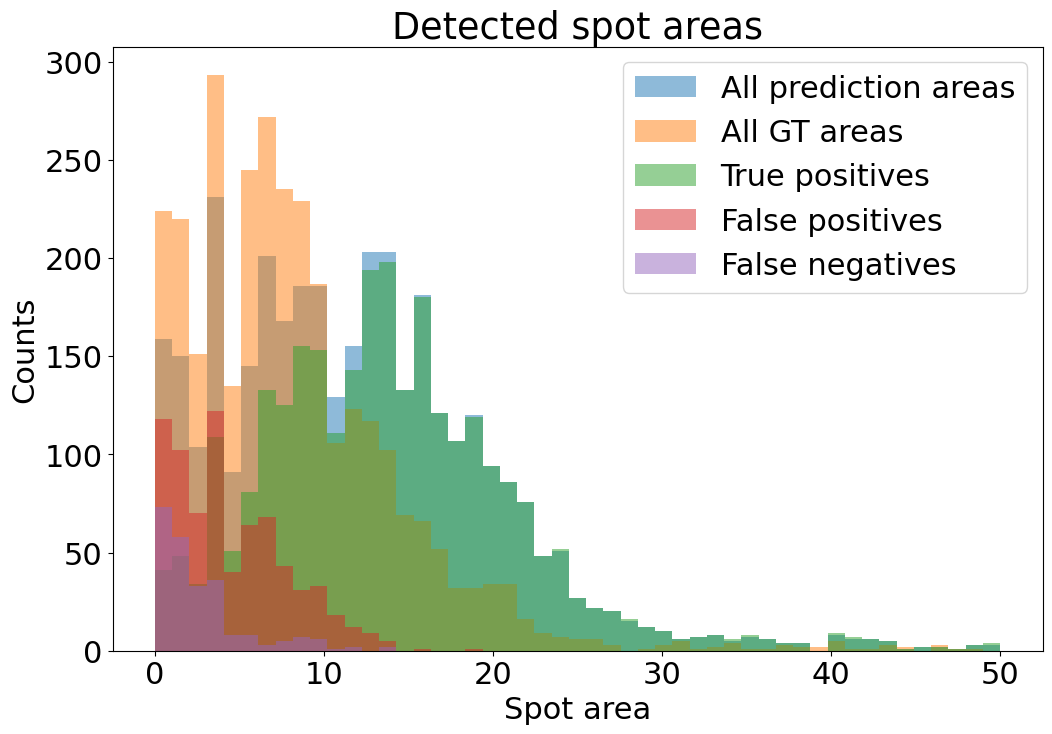

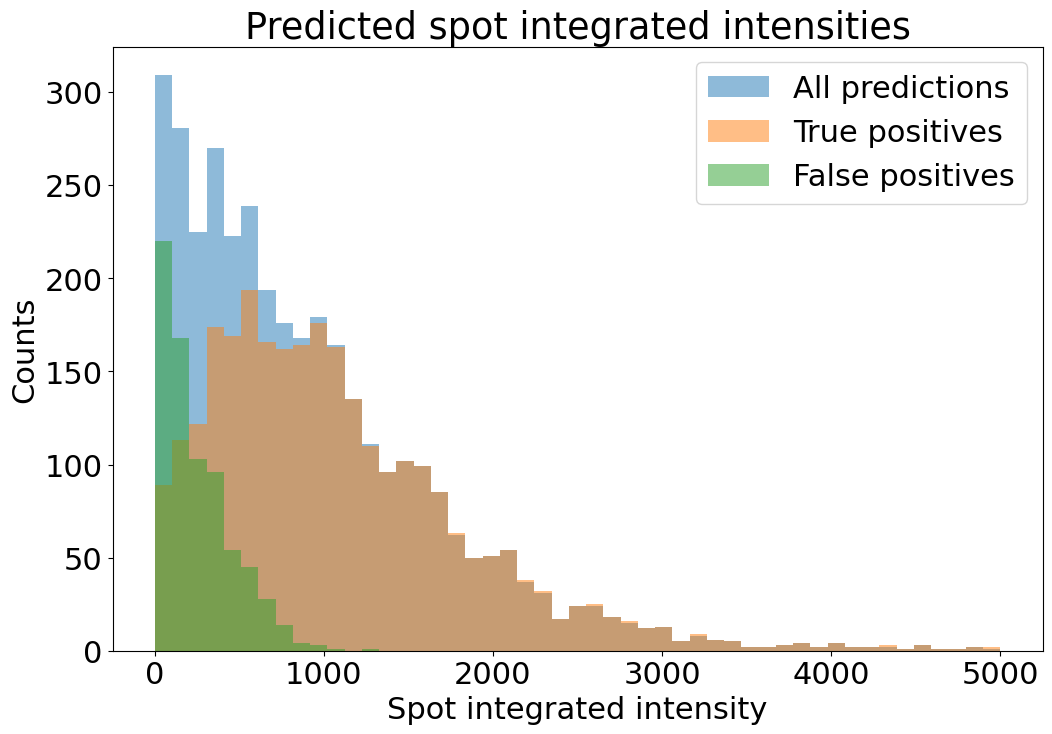

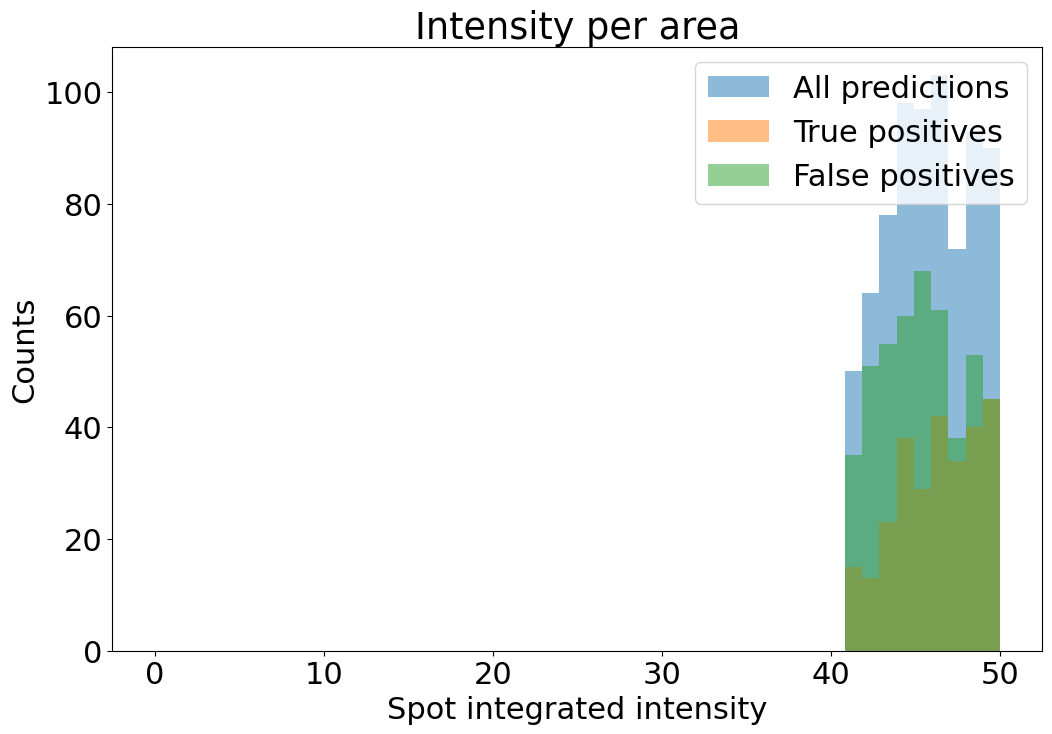

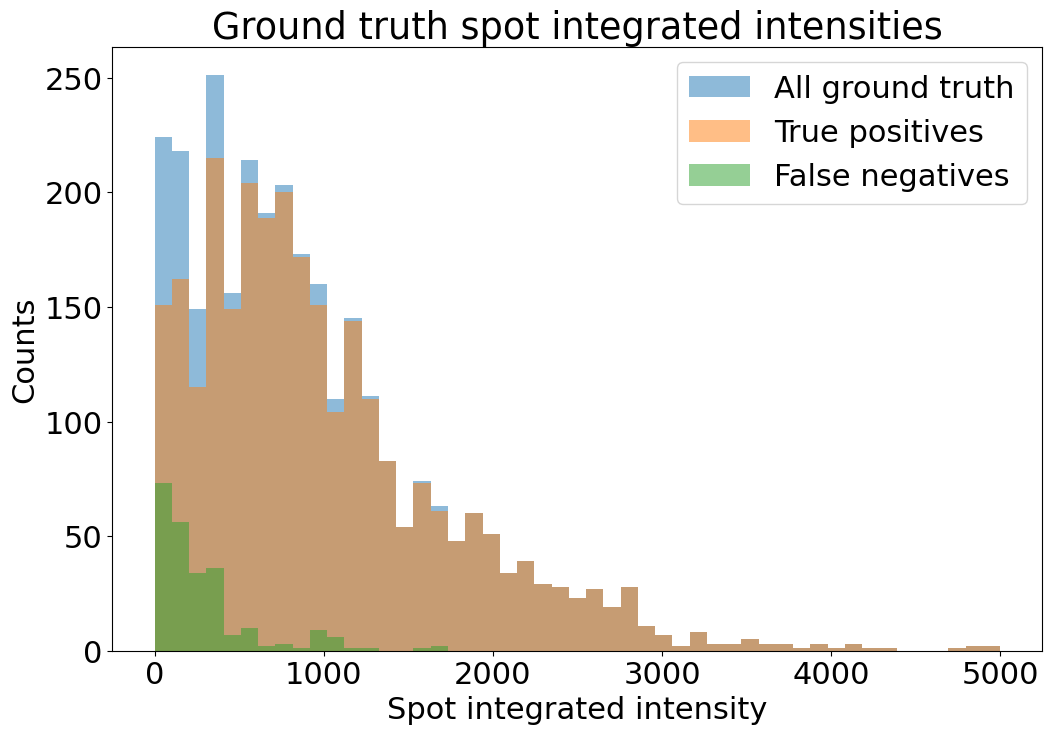

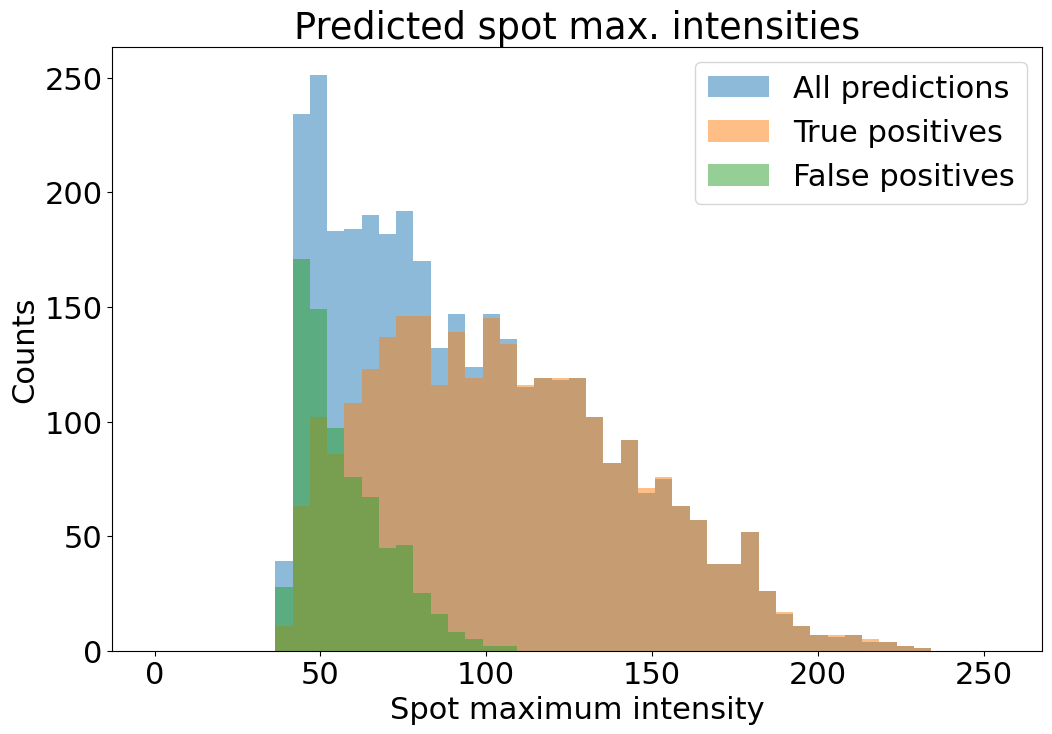

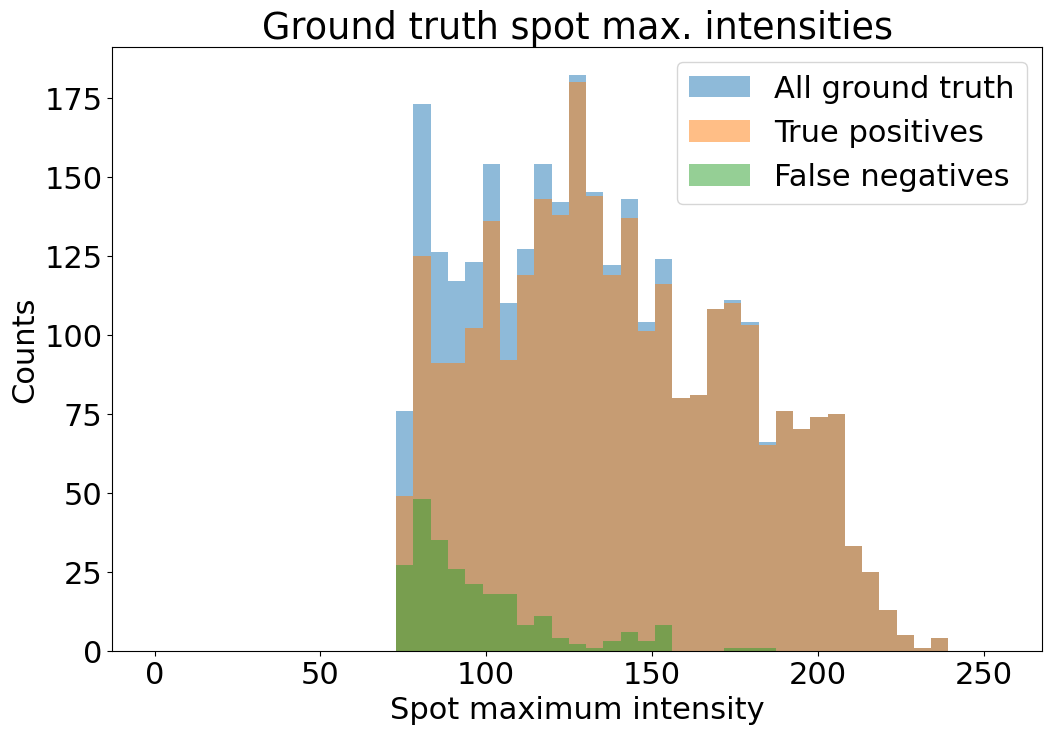

In [28]:


x = TruePosAreas
y = FalsePosAreas
z = FalseNegAreas 
z1 = AllPredictedAreas
z2 = AllGTAreas

bins = np.linspace(0, 50, 50)

plt.hist(z1, bins, label='All prediction areas', alpha=0.5)
plt.hist(z2, bins, label='All GT areas', alpha=0.5)
plt.hist(x, bins, label='True positives', alpha=0.5)
plt.hist(y, bins, label='False positives', alpha=0.5)
plt.hist(z, bins, label='False negatives', alpha=0.5)

plt.legend(loc='upper right')
plt.xlabel('Spot area')
plt.ylabel('Counts')
plt.title('Detected spot areas')
plt.show()


x = TruePosIntInts1
y = FalsePosIntInts
z = AllPredictedIntInts

bins = np.linspace(0, 5000, 50)

plt.hist(z, bins, label='All predictions', alpha=0.5)
plt.hist(x, bins, label='True positives', alpha=0.5)
plt.hist(y, bins, label='False positives', alpha=0.5)

plt.legend(loc='upper right')
plt.xlabel('Spot integrated intensity')
plt.ylabel('Counts')
plt.title('Predicted spot integrated intensities')
plt.show()

x = np.divide(TruePosIntInts1,TruePosAreas)
y = np.divide(FalsePosIntInts,FalsePosAreas)
z = np.divide(AllPredictedIntInts,AllPredictedAreas)

bins = np.linspace(0, 50, 50)

plt.hist(z, bins, label='All predictions', alpha=0.5)
plt.hist(x, bins, label='True positives', alpha=0.5)
plt.hist(y, bins, label='False positives', alpha=0.5)

plt.legend(loc='upper right')
plt.xlabel('Spot integrated intensity')
plt.ylabel('Counts')
plt.title('Intensity per area')
plt.show()

x = TruePosIntInts2
y = FalseNegIntInts
z = AllGTIntInts

bins = np.linspace(0, 5000, 50)

plt.hist(z, bins, label='All ground truth', alpha=0.5)
plt.hist(x, bins, label='True positives', alpha=0.5)
plt.hist(y, bins, label='False negatives', alpha=0.5)

plt.legend(loc='upper right')
plt.xlabel('Spot integrated intensity')
plt.ylabel('Counts')
plt.title('Ground truth spot integrated intensities')
plt.show()

bins = np.linspace(0, 255, 50)

x = TruePosIntMax1
y = FalsePosIntMax
z= AllPredictedIntMax

plt.hist(z, bins, label='All predictions', alpha=0.5)
plt.hist(x, bins, label='True positives', alpha=0.5)
plt.hist(y, bins, label='False positives', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Spot maximum intensity')
plt.ylabel('Counts')
plt.title('Predicted spot max. intensities')
plt.show()

x = TruePosIntMax2
y = FalseNegIntMax
z = AllGTIntMax

plt.hist(z, bins, label='All ground truth', alpha=0.5)
plt.hist(x, bins, label='True positives', alpha=0.5)
plt.hist(y, bins, label='False negatives', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Spot maximum intensity')
plt.ylabel('Counts')
plt.title('Ground truth spot max. intensities')
plt.show()



###Plot readout correlation

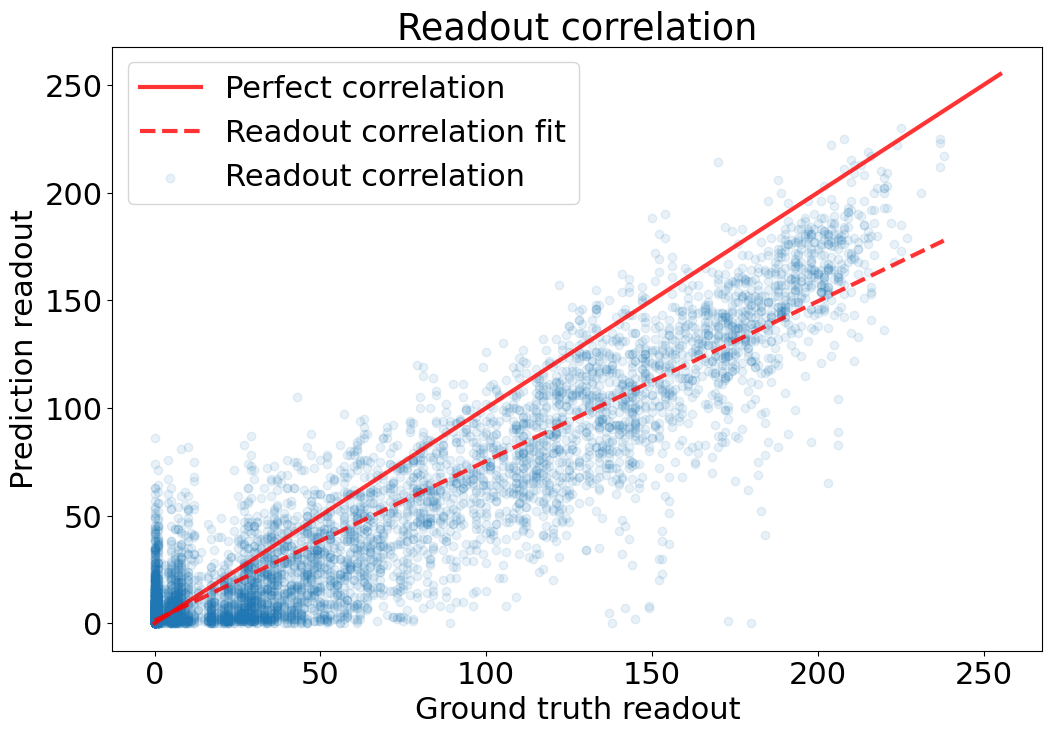

In [43]:
x=MaxGTReadout
y=MaxPredReadout

font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 22}

rc('font', **font)

plt.scatter(x,y,label='Readout correlation',alpha=0.1)
plt.plot([0, 255],[0, 255],'r',linewidth=3,label='Perfect correlation',alpha=0.8)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'r--',linewidth=3,label='Readout correlation fit',alpha=0.8)

plt.legend(loc='upper left')
plt.xlabel('Ground truth readout')
plt.ylabel('Prediction readout')
plt.title('Readout correlation')

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.show()



In [ ]:
# GT int filter first column, pred int filter second column

TruePosOp=np.array([[20, 20, 50.027517886626306],
           [20, 15, 50.575916230366495 ],
           [20, 10, 49.27884615384615 ],
           [15, 10, 47.94646977388094 ],
           [25, 10, 50.437017994858614 ],
           [25, 15, 52.60475651189128] ,
           [30, 15, 54.18927064496685] ,
           [35, 15, 56.1381074168798 ],
           [45, 15, 58.24634655532359 ],
           [45, 20, 61.077389984825494 ],
           [45, 25, 61.507618283881314 ],
           [50, 20, 61.28024980483997 ],
           [5, 5, 44.09448818897638 ],
           [50, 50, 60.05830903790088 ],
           [50, 5, 42.78776104905294 ],
           [5, 50, 31.493038886221797 ],
           [100, 100, 53.99644760213144 ],
           [75, 75, 59.060402684563755 ],
           [100, 75, 64.03225806451613 ],
           [100, 50, 63.22147651006711 ],
           [125, 50, 47.05035971223022 ],
           [75, 50, 68.04374240583232],
           [75, 30, 63.516260162601625 ],
           [60, 40, 66.32337796086509 ],
           [90, 60, 66.4804469273743 ],
           [60, 30, 64.86742424242425 ],
           [75, 40, 66.55443322109988 ],
           [50, 30,63.77952755905512  ],
           [50, 40, 62.90773532152843 ],
           [60, 60, 62.315550510783204 ],
           [90, 40, 62.04465334900117 ]])

FalsePosOp=np.array([[20, 20, 10.0715465052284 ],
           [20, 15, 14.502617801047121 ],
           [20, 10, 21.53846153846154 ],
           [15, 10, 19.981541301338254 ],
           [25, 10, 25.398457583547557 ],
           [25, 15, 17.780294450736125 ],
           [30, 15, 20.494273658830622 ],
           [35, 15, 23.081841432225065 ],
           [45, 15, 27.9053583855254 ],
           [45, 20, 21.396054628224583 ],
           [45, 25, 16.920609462710505 ],
           [50, 20, 23.80952380952381 ],
           [5, 5, 26.055833929849676 ],
           [50, 50, 5.053449951409135 ],
           [50, 5, 52.6469159786304],
           [5, 50, 0.672107537205953 ],
           [100, 100, 2.664298401420959 ],
           [75, 75, 4.026845637583893 ],
           [100, 75, 11.612903225806452 ],
           [100, 50, 26.44295302013423 ],
           [125, 50, 49.064748201438846 ],
           [75, 50, 13.122721749696233 ],
           [75, 30, 27.33739837398374 ],
           [60, 40, 12.976313079299691 ],
           [90, 60, 14.804469273743017 ],
           [60, 30, 19.981060606060606  ],
           [75, 40, 19.753086419753085 ],
           [50, 30,14.610673665791776  ],
           [50, 40, 8.946877912395154 ],
           [60, 60, 4.0862656072644725  ],
           [90, 40, 28.319623971797885 ]])

FalseNegOp=np.array([[20, 20, 39.900935608145296 ],
           [20, 15, 34.92146596858639 ],
           [20, 10, 29.182692307692307 ],
           [15, 10, 32.071988924780804 ],
           [25, 10, 24.164524421593832],
           [25, 15, 29.614949037372593 ],
           [30, 15, 25.31645569620253 ],
           [35, 15, 20.78005115089514 ],
           [45, 15, 13.84829505915101],
           [45, 20, 17.526555386949923], 
           [45, 25, 21.57177225340818 ],
           [50, 20, 14.910226385636221 ],
           [5, 5, 29.849677881173942 ],
           [50, 50, 34.88824101068999 ],
           [50, 5, 4.565322972316658 ],
           [5, 50, 67.83485357657226],
           [100, 100, 43.3392539964476 ],
           [75, 75, 36.91275167785235 ],
           [100, 75, 24.35483870967742 ],
           [100, 50, 10.335570469798657],
           [125, 50, 3.884892086330935  ],
           [75, 50, 18.833535844471445 ],
           [75, 30, 9.146341463414634 ],
           [60, 40, 20.700308959835223 ],
           [90, 60, 18.71508379888268 ],
           [60, 30, 15.151515151515152 ],
           [75, 40, 13.692480359147027 ],
           [50, 30, 21.609798775153106 ],
           [50, 40, 28.14538676607642 ],
           [60, 60, 33.59818388195233  ],
           [90, 40, 9.63572267920094 ]])



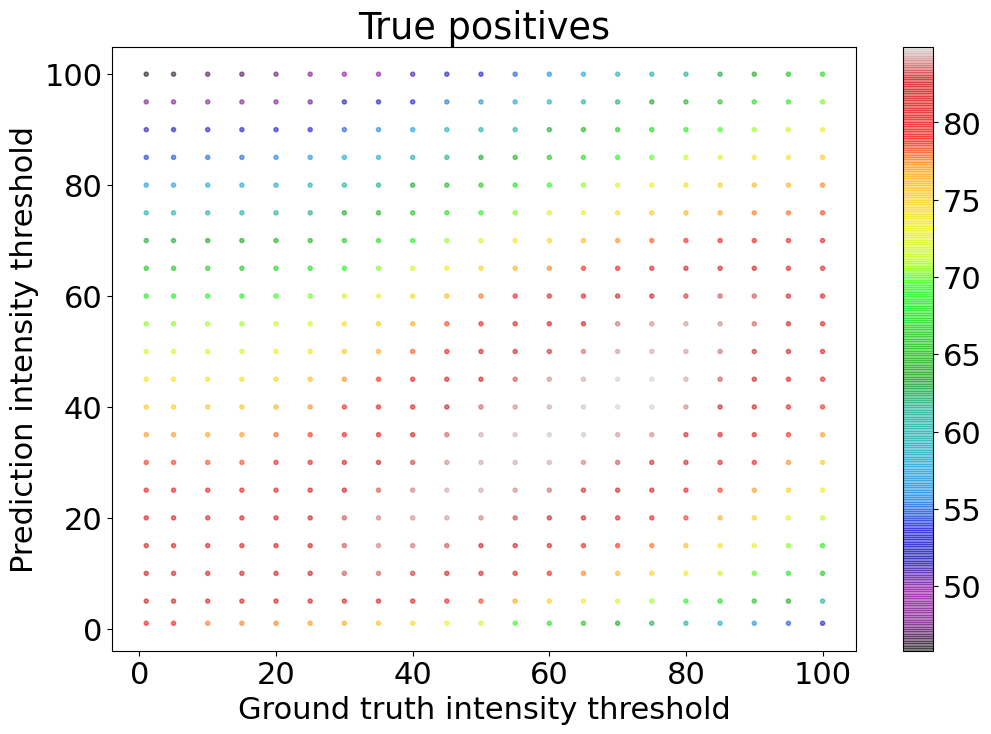

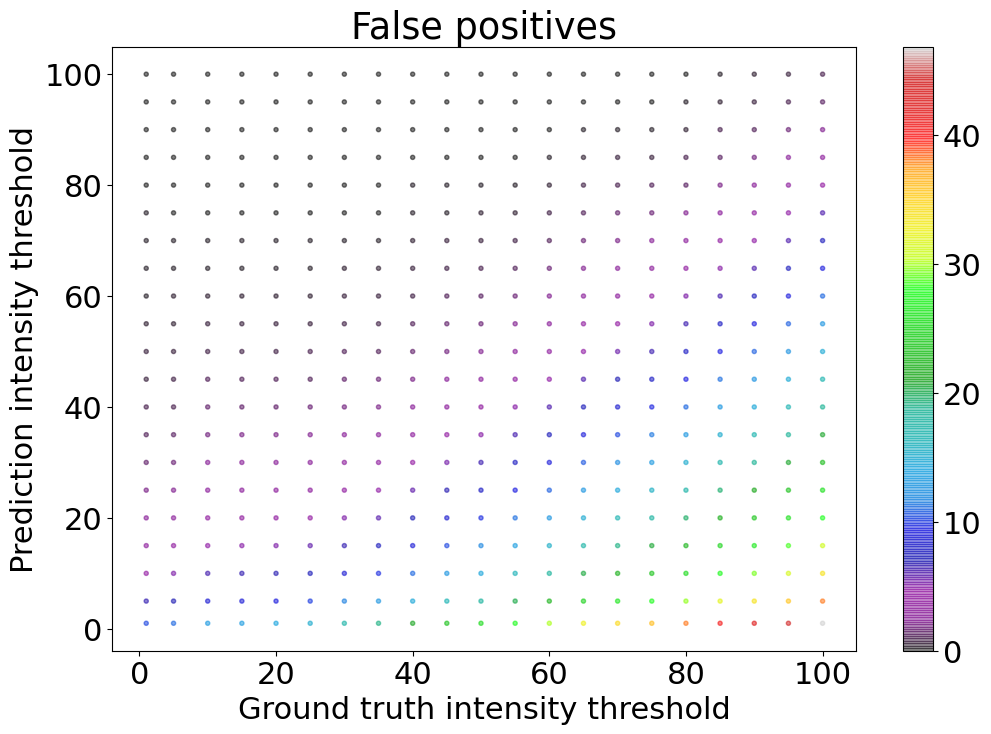

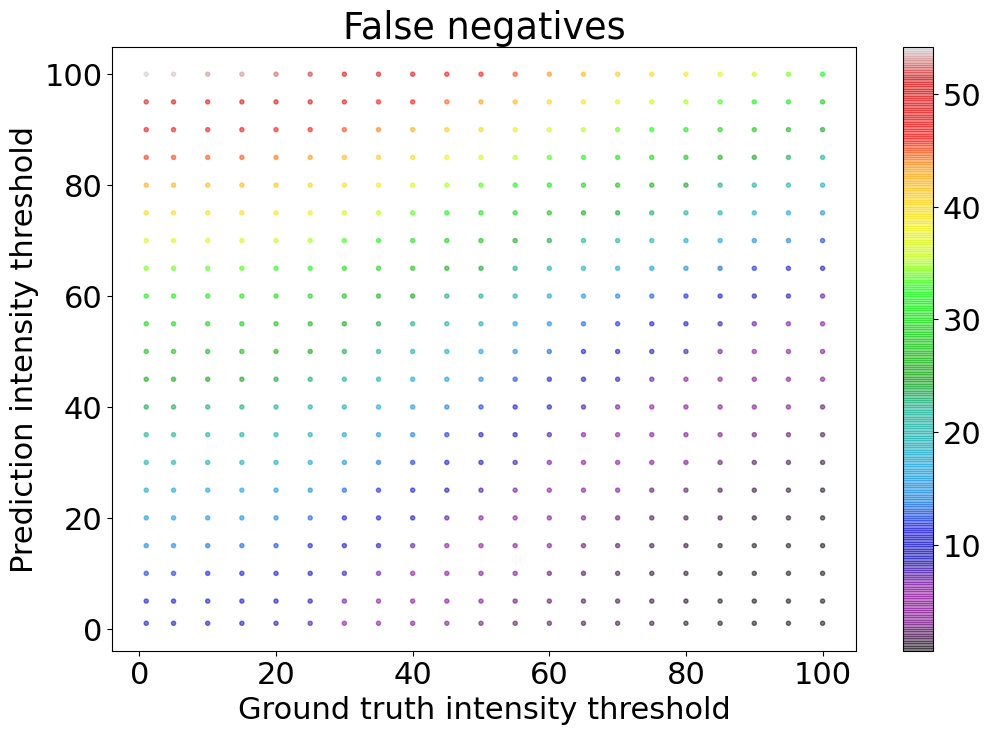

In [22]:
#Performance=np.append(Performance, [[ThresIntPred, ThresIntGT, MaxDist, ThresAreaPred, ThresAreaGT, TotalTruePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives), TotalFalsePositives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives), TotalFalseNegatives*100/(TotalTruePositives+TotalFalseNegatives+TotalFalsePositives)]],axis=0)

x=Performance[:,1]
y=Performance[:,0]
#colors=np.linspace(0,1,10)
B=Performance[:,5]

cs = plt.scatter(x,y,c=B,marker='.',cmap=cm.nipy_spectral,vmin=np.amin(B),vmax=np.amax(B),label='True positives [%]',alpha=0.5)
plt.colorbar(cs)
x=Performance[:,1]
y=Performance[:,0]
plt.xlabel('Ground truth intensity threshold')
plt.ylabel('Prediction intensity threshold')
plt.title('True positives')
plt.show()
#colors=np.linspace(0,1,10)
B=Performance[:,6]
cs = plt.scatter(x,y,c=B,marker='.',cmap=cm.nipy_spectral,vmin=np.amin(B),vmax=np.amax(B),label='False positives [%]',alpha=0.5)
plt.colorbar(cs)
plt.xlabel('Ground truth intensity threshold')
plt.ylabel('Prediction intensity threshold')
plt.title('False positives')
x=Performance[:,1]
y=Performance[:,0]
plt.show()
#colors=np.linspace(0,1,10)
B=Performance[:,7]
cs = plt.scatter(x,y,c=B,marker='.',cmap=cm.nipy_spectral,vmin=np.amin(B),vmax=np.amax(B),label='False negatives [%]',alpha=0.5)
plt.colorbar(cs)
plt.xlabel('Ground truth intensity threshold')
plt.ylabel('Prediction intensity threshold')
plt.title('False negatives')
plt.show()

In [24]:
print(np.amax(Performance[:,5]))

84.90151005629309
